In [1]:
import sys
sys.path += ["../src"]
import climact_utils as cu
# import features_cox_week as ft
import logistic_regression_activation as L
import pandas as pd
from glob import glob
import numpy as np
import cox_logreg_experiments as cle
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import subplots as sbp

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
from importlib import reload

In [3]:
exp_path = cu.data_path + "experiments_logreg"

In [5]:
subreddit_class = "activism"

In [6]:
lr = L.LogisticRegression_activation("activism")

In [7]:
# lr.load_data()
# df = lr.df
# df.to_csv(cu.data_path + f"authors_featurs_df/{subreddit_class}.csv.gz", compression = "gzip")
df = pd.read_csv(cu.data_path + f"authors_featurs_df/{subreddit_class}.csv.gz", compression = "gzip", index_col = [0,1])
lr.df = df


#### Different groups on features

In [8]:
features_classes = ['control', 'interaction', 'norm_news', 'subreddit', 'sociodemo']

In [9]:
experiments_features = {}

for feature_class in features_classes:
    print(feature_class)
    experiments_features[feature_class + "_all_times"] = lr.repeated_bootstrap(n_samples = 100, test = True, select_features = [feature_class])
for feature_class in features_classes:

    print("no", feature_class)
    experiments_features["no_" + feature_class + "_all_times"] = lr.repeated_bootstrap(n_samples = 100, test = True, select_features = [u for u in features_classes if u != feature_class])

print("all")
experiments_features["all" + "_all_times"] = lr.repeated_bootstrap(n_samples = 100, test = True)


control
interaction
norm_news
subreddit
sociodemo
no control
no interaction
no norm_news
no subreddit
no sociodemo
all


In [10]:
performances_experiments_features = pd.concat([experiments_features[u][1].assign(selected_features = u) 
                                               for u in experiments_features.keys()]).reset_index().rename(columns = {"index": "measure"}).set_index(["selected_features","measure"]).unstack()
performances_experiments_features

mean                                      \
measure                   accuracy precision random_baseline    recall   
selected_features                                                        
all_all_times             0.695699  0.743942        0.509116  0.594877   
control_all_times         0.628086  0.639181        0.508152  0.585838   
interaction_all_times     0.670235  0.756168        0.509139  0.500756   
no_control_all_times      0.696416  0.747926        0.508751  0.592442   
no_interaction_all_times  0.691975  0.737506        0.509507  0.595714   
no_norm_news_all_times    0.692826  0.744623        0.508546  0.587189   
no_sociodemo_all_times    0.695970  0.747377        0.509519  0.591459   
no_subreddit_all_times    0.696442  0.720788        0.509256  0.640700   
norm_news_all_times       0.632831  0.637015        0.508026  0.615432   
sociodemo_all_times       0.578907  0.574173        0.509067  0.602553   
subreddit_all_times       0.682441  0.733740        0.508621  0.572159   

                               std                                      
measure                   accuracy precision random_baseline    recall  
selected_features                                                       
all_all_times             0.010338  0.017657        0.006773  0.023658  
control_all_times         0.010919  0.016810        0.006158  0.023209  
interaction_all_times     0.010060  0.018827        0.006508  0.020435  
no_control_all_times      0.009495  0.014822        0.006610  0.019154  
no_interaction_all_times  0.011956  0.017603        0.006997  0.020367  
no_norm_news_all_times    0.011882  0.016705        0.005814  0.023269  
no_sociodemo_all_times    0.011411  0.018630        0.007491  0.020312  
no_subreddit_all_times    0.010573  0.016870        0.007156  0.018743  
norm_news_all_times       0.011282  0.015434        0.006455  0.020248  
sociodemo_all_times       0.011172  0.015959        0.007099  0.034797  
subreddit_all_times       0.011250  0.018139        0.006934  0.023307

In [11]:
performances_experiments_features["std"]["accuracy"]

selected_features
all_all_times               0.010338
control_all_times           0.010919
interaction_all_times       0.010060
no_control_all_times        0.009495
no_interaction_all_times    0.011956
no_norm_news_all_times      0.011882
no_sociodemo_all_times      0.011411
no_subreddit_all_times      0.010573
norm_news_all_times         0.011282
sociodemo_all_times         0.011172
subreddit_all_times         0.011250
Name: accuracy, dtype: float64

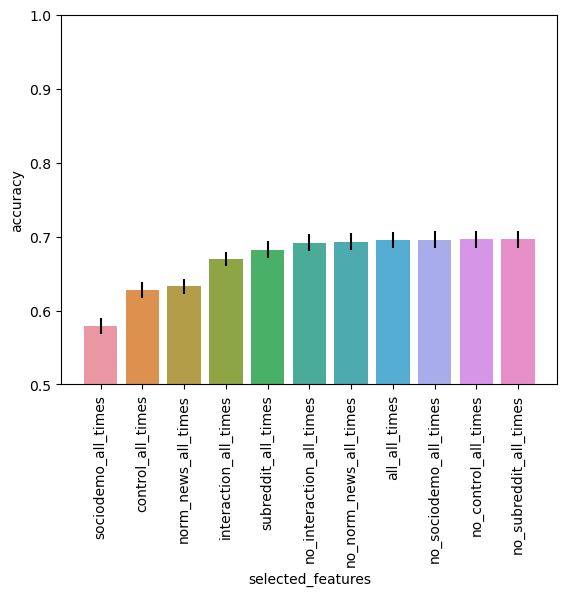

In [12]:
fig, axes = sbp()
sns.barplot(data = performances_experiments_features["mean"].reset_index().sort_values("accuracy"), x = "selected_features", y = "accuracy", ax = axes)
axes.errorbar(x = performances_experiments_features["mean"].reset_index().sort_values("accuracy")["selected_features"], 
              y = performances_experiments_features["mean"].reset_index().sort_values("accuracy")["accuracy"],
              yerr = performances_experiments_features["std"]["accuracy"],
              fmt = "none", c = "black")
plt.xticks(rotation = 90)
axes.set_ylim([.5,1])
fig.show()

#### Different time periods

In [13]:
print("all_times")
experiments_features["all_times"] = lr.repeated_bootstrap(n_samples = 100, test = True, select_features = features_classes)

for time in ["short", "medium", "long", "ratio"]:
    print(time)
    experiments_features[time] = lr.repeated_bootstrap(n_samples = 100, test = True, select_features = features_classes, select_time = time)


all_times
short
medium
long
ratio


In [14]:
performances_experiments_times = pd.concat([experiments_features[u][1]
                                            .assign(selected_features =  u + "_all_features") 
                                            for u in ["all_times", "short", "medium", "long", "ratio"]]).reset_index().rename(columns = {"index": "measure"}).set_index(["selected_features","measure"]).unstack()

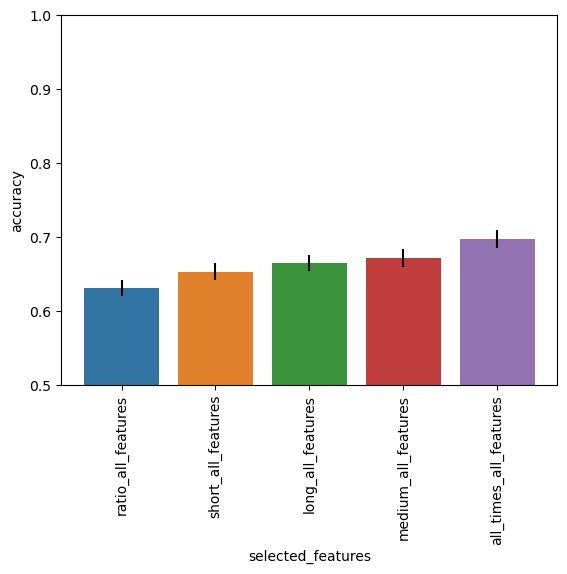

In [15]:
fig, axes = sbp()
sns.barplot(data = performances_experiments_times["mean"].reset_index().sort_values("accuracy"), x = "selected_features", y = "accuracy", ax = axes)
axes.errorbar(x = performances_experiments_times["mean"].reset_index().sort_values("accuracy")["selected_features"], 
              y = performances_experiments_times["mean"].reset_index().sort_values("accuracy")["accuracy"],
              yerr = performances_experiments_times["std"]["accuracy"],
              fmt = "none", c = "black")

plt.xticks(rotation = 90)
axes.set_ylim([.5,1])
fig.show()

In [16]:
print("all_times")
experiments_features["all_times_no_subreddit"] = lr.repeated_bootstrap(n_samples = 100, test = True, select_features = ['control', 'interaction', 'norm_news', 'sociodemo'])

for time in ["short", "medium", "long", "ratio"]:
    print(time)
    experiments_features[time + "_no_subreddit"] = lr.repeated_bootstrap(n_samples = 100, test = True, select_features = ['control', 'interaction', 'norm_news', 'sociodemo'], select_time = time)


all_times
short
medium
long
ratio


In [17]:
performances_experiments_times_no_subreddit = (pd.concat([experiments_features[u + "_no_subreddit"][1].assign(selected_features =  u + "_no_subreddit")
                                                          for u in ["all_times", "short", "medium", "long", "ratio"]])
                                                          .reset_index()
                                                          .rename(columns = {"index": "measure"})
                                                          .set_index(["selected_features","measure"]).unstack())

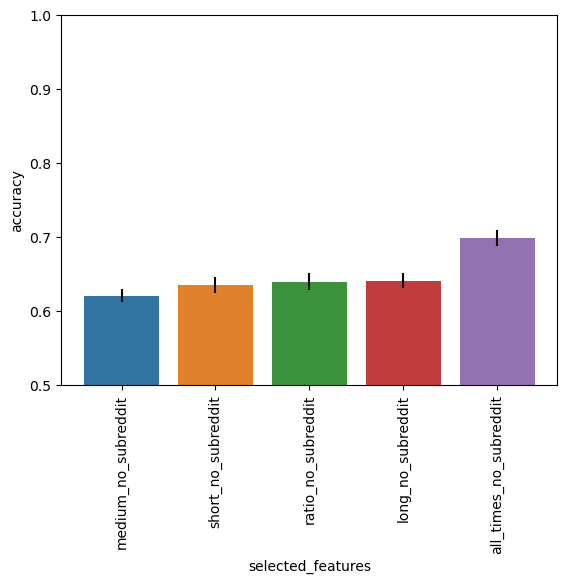

In [18]:
fig, axes = sbp()
sns.barplot(data = performances_experiments_times_no_subreddit["mean"].reset_index().sort_values("accuracy"), x = "selected_features", y = "accuracy", ax = axes)
axes.errorbar(x = performances_experiments_times_no_subreddit["mean"].reset_index().sort_values("accuracy")["selected_features"], 
              y = performances_experiments_times_no_subreddit["mean"].reset_index().sort_values("accuracy")["accuracy"],
              yerr = performances_experiments_times_no_subreddit["std"]["accuracy"],
              fmt = "none", c = "black")

plt.xticks(rotation = 90)
axes.set_ylim([.5,1])
fig.show()

In [19]:
pd.concat([experiments_features[u][1].assign(selected_features = u) for u in experiments_features.keys()]).reset_index().rename(columns = {"index": "measure"}).set_index(["selected_features","measure"]).unstack().to_csv(exp_path + "performance_selected_features_and_times_240712.csv")
pd.concat([experiments_features[u][0].assign(selected_features = u) for u in experiments_features.keys()]).reset_index().rename(columns = {"index": "feature"}).set_index(["selected_features", "feature"]).to_csv(exp_path + "coef_ci_selected_features_and_times_240712.csv")

In [20]:
performance_df = pd.read_csv(exp_path + "performance_selected_features_and_times_240712.csv", index_col=[0], header=2, names = ["_".join([u,m]) for m in ["mean", "std"] for u in ["accuracy", "precision", "recall", "random_baseline"]])

In [21]:
performance_df.loc[[u for u in performance_df.index if "no_subreddit" in u]].sort_values("accuracy_mean")

,accuracy_mean,precision_mean,recall_mean,random_baseline_mean,accuracy_std,precision_std,recall_std,random_baseline_std
medium_no_subreddit,0.620482,0.662515,0.509350,0.492345,0.011388,0.021520,0.006233,0.028955
short_no_subreddit,0.635004,0.677222,0.509021,0.516823,0.010855,0.019269,0.005544,0.027688
ratio_no_subreddit,0.639364,0.661910,0.509280,0.567304,0.010359,0.017774,0.006529,0.025292
long_no_subreddit,0.640507,0.642411,0.508216,0.629302,0.010858,0.014536,0.006592,0.025119
no_subreddit_all_times,0.696442,0.720788,0.509256,0.640700,0.010573,0.016870,0.007156,0.018743
all_times_no_subreddit,0.697946,0.724595,0.508025,0.639807,0.009414,0.014553,0.006246,0.019858


In [22]:
coefs_df = pd.read_csv(exp_path + "coef_ci_selected_features_and_times_240712.csv", index_col = [0,1])

In [23]:
coefs_df.loc["all_all_times"].loc[[w for u in list(cu.features_time["control"].values()) for w in u]].sort_values("coef", ascending = False)

,coef,CI_lower,CI_upper
feature,,,
n_different_subreddits_short,0.025624,0.019203,0.031112
n_comments_author_week_short,0.023563,0.015923,0.030333
n_different_subreddits_short_long_ratio,0.021801,0.014449,0.032168
n_submissions_author_week_short,0.021544,0.009524,0.036520
n_active_days_author_week_short,0.020338,0.014926,0.025651
n_different_subreddits_medium,0.019365,0.014444,0.024933
n_active_days_author_week_short_long_ratio,0.019007,0.012700,0.026664
n_comments_author_week_medium,0.018706,0.012663,0.026572
n_submissions_author_week_medium,0.016921,0.002795,0.030008


In [24]:
coefs_df.loc["all_all_times"].loc[[w for u in list(cu.features_time["interaction"].values()) for w in u]].sort_values("coef", ascending = False)

,coef,CI_lower,CI_upper
feature,,,
n_different_active_authors_parent_id_id_short,0.037518,0.026505,0.048240
n_different_active_authors_id_parent_id_short,0.037147,0.028031,0.048866
n_different_active_authors_id_parent_id_medium,0.035568,0.026969,0.046108
n_different_comments_with_active_parent_id_id_short,0.034180,0.024478,0.045879
n_different_active_authors_parent_id_id_medium,0.033168,0.023493,0.044948
n_different_comments_with_active_id_parent_id_medium,0.031766,0.022271,0.042362
n_different_comments_with_active_id_parent_id_short,0.030750,0.021797,0.041806
n_different_comments_with_active_parent_id_id_medium,0.029199,0.019977,0.038427
n_different_active_authors_link_id_link_id_short,0.024247,0.018028,0.032401


In [25]:
coefs_df.loc["all_all_times"].loc[[w for u in list(cu.features_time["norm_news"].values()) for w in u]].sort_values("coef", ascending = False)

,coef,CI_lower,CI_upper
feature,,,
norm_natural_disaster_long,0.015306,0.010252,0.020837
norm_climate_medium,0.013524,0.006534,0.022466
norm_climate_action_short_long_ratio,0.013130,0.006298,0.020786
norm_climate_short,0.011739,0.004504,0.019189
norm_climate_action_short,0.010392,0.003502,0.017485
norm_climate_action_medium,0.009993,0.003016,0.017402
norm_climate_short_long_ratio,0.009537,0.003149,0.016830
norm_natural_disaster_medium,0.007416,0.002623,0.013541
norm_natural_disaster_short,0.006154,0.000765,0.012094


In [26]:
coefs_df.loc["all_all_times"].loc[cu.features["sociodemo"]]

,coef,CI_lower,CI_upper
feature,,,
sociodemo_young,-0.007416,-0.010818,-0.003732
sociodemo_old,0.005352,0.001121,0.010106
sociodemo_male,-0.003691,-0.007546,-0.000413
sociodemo_female,0.003248,-0.001342,0.008243
sociodemo_left,0.018302,0.014368,0.022203
sociodemo_right,-0.016000,-0.020623,-0.012068
sociodemo_poor,0.008749,0.004073,0.013152
sociodemo_rich,-0.007284,-0.011150,-0.003103


In [27]:
coefs_df.loc["all_all_times"].loc[list(set(["r" + w for u in list(cu.features_time["subreddit"].values()) for w in u])&set(coefs_df.loc["all_all_times"].index))].sort_values("coef", ascending = False).head(20)

,coef,CI_lower,CI_upper
feature,,,


In [28]:
coefs_df.loc["all_all_times"].loc[list(set(["r" + w for u in list(cu.features_time["subreddit"].values()) for w in u])&set(coefs_df.loc["all_all_times"].index))].sort_values("coef", ascending = True).head(20)

,coef,CI_lower,CI_upper
feature,,,


#### Non overlapping authors

In [29]:
more_obs_authors = list(df.reset_index().groupby(["author"]).mean(numeric_only=True).query("0<activation<1").index)

In [30]:
lr_no_overlapping = L.LogisticRegression_activation("activism")
lr_no_overlapping.df = df.loc[~df.index.isin(list(df.loc[more_obs_authors].index))]
exp_no_overlapping = lr_no_overlapping.repeated_bootstrap(n_samples = 10, test = True)

In [31]:
exp_no_overlapping[1]

,mean,std
accuracy,0.721492,0.008537
precision,0.773105,0.011372
recall,0.639164,0.015446
random_baseline,0.509683,0.006930


In [32]:
exp_no_overlapping[0].sort_values("coef", ascending = False).head(20)

,coef,CI_lower,CI_upper
n_different_active_authors_id_parent_id_short,0.047095,0.037833,0.054087
n_different_active_authors_parent_id_id_short,0.046588,0.036721,0.054737
n_different_active_authors_id_parent_id_medium,0.045861,0.038725,0.057004
n_different_comments_with_active_parent_id_id_short,0.040427,0.031140,0.050819
n_different_active_authors_parent_id_id_medium,0.040160,0.030238,0.052839
n_different_comments_with_active_id_parent_id_short,0.039206,0.031364,0.047581
n_different_comments_with_active_id_parent_id_medium,0.039074,0.031684,0.050283
n_different_subreddits_short,0.036820,0.032443,0.041840
rCOMPLETEANARCHY_medium,0.036236,0.028534,0.041345
rChapoTrapHouse_medium,0.035128,0.030187,0.040718


#### Only overlapping authors

In [33]:
more_obs_authors = list(df.reset_index().groupby(["author"]).mean(numeric_only=True).query("0<activation<1").index)

In [34]:
lr_only_overlapping = L.LogisticRegression_activation("activism")
lr_only_overlapping.df = df.loc[df.index.isin(list(df.loc[more_obs_authors].index))]
exp_only_overlapping = lr_only_overlapping.repeated_bootstrap(n_samples = 10, test = True)

In [35]:
exp_only_overlapping[1]

,mean,std
accuracy,0.582893,0.023678
precision,0.586655,0.052006
recall,0.410419,0.089956
random_baseline,0.531023,0.015552


In [36]:
exp_only_overlapping[0].sort_values("coef", ascending = False).head(20)

,coef,CI_lower,CI_upper
n_different_active_authors_link_id_link_id_long,0.014696,0.010335,0.018539
n_different_active_authors_parent_id_parent_id_long,0.012561,0.009108,0.017284
n_different_active_authors_id_parent_id_long,0.011277,0.005489,0.017329
n_different_comments_with_active_link_id_link_id_long,0.011019,0.006418,0.015659
n_different_comments_with_active_id_parent_id_long,0.010665,0.005770,0.015997
rFuckYouKaren_short,0.009870,0.000026,0.021342
rfireemblem_short_long_ratio,0.009870,0.000026,0.021342
rTerraria_short,0.009870,0.000026,0.021342
rfireemblem_short,0.009870,0.000026,0.021342
rthedivision_medium,0.009870,0.000026,0.021342
